In [24]:
import torch
import os
import glob
import uproot
from torch.utils.data import Dataset
import models
from utils import VBSConfig, print_title
from losses import DisCoLoss
from datasets import DisCoDataset
from train import get_outfile
from torch.utils.data import DataLoader
import numpy as np

In [32]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"use_cuda: {use_cuda}")

use_cuda: False


In [39]:
config=VBSConfig.from_json("config_test.json")
models_dir=f"{config.basedir}/trained_models"
test_datapath=get_outfile(config, tag="test_dataset")
test_datapath

'/home/users/joytzphysics/Analysis/abcdnet/trained_models/ABCDNet_DoubleGaussian_modelNeuralNetwork_nhidden3_hiddensize128_lr0.001_discolambda1000_test_dataset.pt'

In [40]:
model_name="ABCDNet_DoubleGaussian_modelNeuralNetwork_nhidden3_hiddensize128_lr0.001_discolambda1000_epoch50_model.pt"
model_path=os.path.join(models_dir,model_name)
Model=getattr(models, config.model.name)
model=Model.from_config(config).to(device)

----------------- Neural Network -----------------
NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [41]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [16]:
test_data=test_data = DisCoDataset.from_files(
    test_datapath, 
    is_single_disco=(config.ingress.get("disco_target", None) != None)
)

In [22]:
test_loader = DataLoader(test_data, batch_size=config.train.test_batch_size, shuffle=True)

In [43]:
y_pred_list = []
y_true_list = []

model.eval()
with torch.no_grad():
    for batch_i, (features, labels, weights, disco_target) in enumerate(test_loader):
        # Load data
        output = model(features)
        y_pred_list.append(output.cpu().numpy())
        y_true_list.append(labels.cpu().numpy())

y_pred_np = np.concatenate(y_pred_list)
y_true_np = np.concatenate(y_true_list)

In [44]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true_np, y_pred_np)


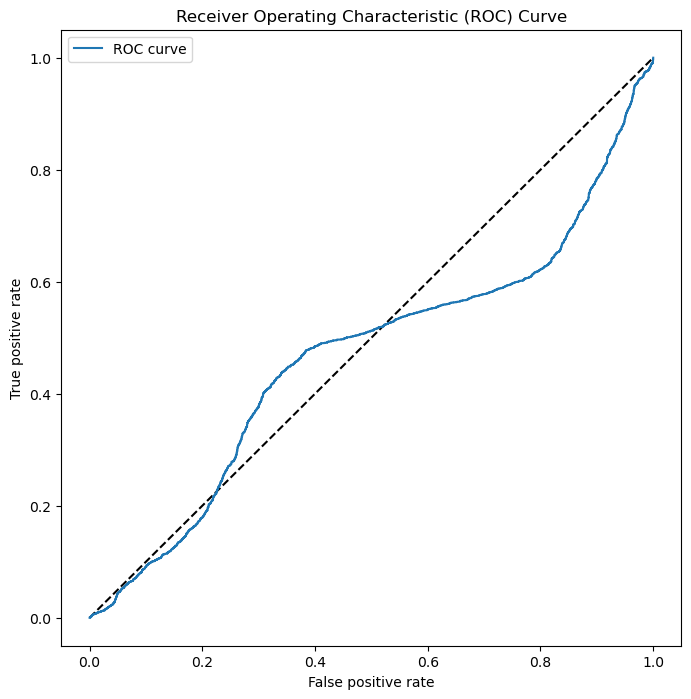

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [47]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_true_np, y_pred_np[:, 1])

IndexError: index 1 is out of bounds for axis 1 with size 1